# Modelagem de sequências com RNNs

Quando queremos passar de sequências de embeddings de palavras para uma representação vetorial de documento que pode ser classificada, precisamos de alguma forma resumir uma sequência de vetores em um único vetor. Até agora, o que temos feito é:

1. Obter um embedding $e \in \mathbb{R}^{l \times d}$ por token, onde $l$ é o comprimento da sequência e $d$ é a dimensão do embedding. Isso gera a matriz de embeddings $E \in \mathbb{R}^{b \times l \times d}$, onde $b$ é o tamanho do batch.
2. Calcular a média ao longo do tempo de $E$, gerando $X \in \mathbb{R}^{b \times d}$.
3. Prosseguir para a classificação com nossa regressão logística.

Essa estrutura pode ser ilustrada da seguinte forma:

```mermaid
graph LR;

    subgraph Embedding;
    D(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"])
    end;

    subgraph Resumo;
    D --> E(["Média ao longo do tempo"]) --> F(["Embeddings ($$X \in \\mathbb{R}^{b \\times d}$$)"])
    end;

    subgraph Classificação;
    F --> G(["Regressão Logística"]) --> H(["$$P(C_i=c_j \\mid X_i)$$"])
    end;
```

---

## Limitações da média temporal

- **Perda de ordenação:** Ao fazer a média, ignoramos completamente em que ordem as palavras aparecem. Sequências com significados diferentes podem ter a mesma média.
- **Dependências de longo alcance:** Informações que aparecem no início ou no fim do texto são tratadas igualmente, sem distinção de sua importância contextual.

Para superar essas limitações, apresentamos as *Recurrent Neural Networks* (RNNs).

---

## Introdução às RNNs

Em uma RNN padrão, processamos a sequência de forma recursiva, atualizando um **vetor de estado** $h_t$ a cada passo de tempo $t$. Esse vetor carrega informação histórica:

$${h_t = \tanh(W_h h_{t-1} + W_x x_t + b) }$$

onde:
- $x_t \in \mathbb{R}^d$ é o embedding do token no passo $t$.
- $h_{t-1} \in \mathbb{R}^h$ é o estado anterior.
- $W_h$ e $W_x$ são matrizes de peso.
- $b$ é o viés.

A cada passo, a RNN "lembra" informação dos tokens anteriores através de $h_{t-1}$. No final, podemos usar $h_l$ (estado após o último token) como um resumo poderoso de toda a sequência, preservando ordem e dependências.

### Vantagens das RNNs

- **Sensibilidade à ordem:** Capturam a sequência exata de palavras.
- **Contexto dinâmico:** Mantêm um estado que evolui conforme novos tokens são processados.

Em seções seguintes, veremos variações como LSTM e GRU, que resolvem problemas de *vanishing gradients* e permitem modelar dependências de longo prazo com ainda mais eficácia.

---

**Próximo passo:** Vamos implementar uma RNN simples em PyTorch para entender seu funcionamento na prática, incluindo a definição do loop temporal, a inicialização do estado oculto e a aplicação para classificação de sequências.



# Modelagem de sequências com RNNs

Quando queremos passar de sequências de embeddings de palavras para uma representação vetorial de documento que pode ser classificada, precisamos de alguma forma resumir uma sequência de vetores em um único vetor. Até agora, o que temos feito é:

1. Obter um embedding $e \in \mathbb{R}^{l \times d}$ por token, onde $l$ é o comprimento da sequência e $d$ é a dimensão do embedding. Isso gera a matriz de embeddings $E \in \mathbb{R}^{b \times l \times d}$, onde $b$ é o tamanho do batch.
2. Calcular a média ao longo do tempo de $E$, gerando $X \in \mathbb{R}^{b \times d}$.
3. Prosseguir para a classificação com nossa regressão logística.

Essa estrutura pode ser ilustrada da seguinte forma:

```mermaid
graph LR;

    subgraph Embedding;
    D(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"])
    end;

    subgraph Resumo;
    D --> E(["Média ao longo do tempo"]) --> F(["Embeddings ($$X \in \\mathbb{R}^{b \\times d}$$)"])
    end;

    subgraph Classificação;
    F --> G(["Regressão Logística"]) --> H(["$$P(C_i=c_j \\mid X_i)$$"])
    end;
```

---

## Limitações da média temporal

A principal desvantagem dessa abordagem é que o cálculo da média desconsidera completamente a **ordem das palavras** — essencialmente, fazemos um modelo de sacola de palavras (bag-of-words), que pode mapear sequências diferentes ao mesmo vetor médio, perdendo nuances de contexto e sintaxe.

## Redes Neurais Recorrentes (RNNs)

Para lidar com dependências sequenciais e preservar a ordem, usamos *Recurrent Neural Networks* (RNNs). Sua ideia central é processar cada passo de tempo $t$ de forma encadeada, permitindo que o modelo "lembre" informações dos tokens anteriores.

### Histórico e Intuição

As RNNs surgiram a partir de contribuições entre as décadas de 1950 e 1970. Começamos com uma simples regressão logística no primeiro passo de tempo:

```mermaid
graph LR;
    F(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"]) -->
    FF(["$$x_e = E_{[0,:,:]}$$"])
    FF --> G(["Regressão Logística"]) --> H(["$$y_0$$"])
```

Em seguida, para o passo $t=1$, concatenamos o embedding atual com a saída anterior $y_0$, formando $x_e = [E_{[1,:,:]}, y_0]$, e geramos uma nova predição $y_1$. Repetimos isso ao longo de todos os passos $t \in [0, l-1]$:

```mermaid
graph LR;
    F(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"])
    FF(["$$x_e = [E_{[t,:,:]}, y_{t-1}]$$"])

    F --> FF
    FF --> G(["Regressão Logística"]) 
    G --> H(["$$y_t$$"])
    H -- "Loop de realimentação" --> FF
```

### De Regressão Logística a Camada Não-Linear

Na prática, substituímos a sigmoide $\sigma(z)$ por uma função não-linear como $	anh(z)$, pois ela admite valores negativos e costuma otimizar melhor:

\[
\tanh(z) = 2\sigma(z) - 1
\]

Assim, nossa atualização de estado fica:

```mermaid
graph LR;
    F(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"])
    FF(["$$x_e = [E_{[t,:,:]}, h_{t-1}]$$"])

    F --> FF
    FF --> G(["$$h_t = \tanh(x_e W^T + b)$$"]) 
    G --> H(["$$h_t$$"])
    H -- "Loop de realimentação" --> FF
```

Aqui, $h_t$ é chamado de **estado oculto** (hidden state), pois é um resultado intermediário que carrega informação histórica da sequência.

### Resumindo a sequência

Ao final de processar todos os $l$ passos, usamos o último estado oculto $h_l$ como o vetor resumo da sequência:

\[ X = h_l, \quad X \in \mathbb{R}^{b \times d_h} \]

Podemos então aplicar uma regressão logística (ou outra camada de decisão) sobre $X$ para classificação:

```mermaid
graph LR;
    subgraph Embedding;
    D(["Embeddings ($$E \in \\mathbb{R}^{b \\times l \\times d}$$)"])
    end;

    subgraph Resumo;
    D --> FF(["$$x_e = [E_{[t,:,:]}, h_{t-1}]$$"])
    FF --> GF(["$$h_t = \tanh(x_e W^T + b)$$"])
    GF --> HF(["$$h_t$$"])
    HF -- "Último estado" --> F(["Embeddings ($$X \in \\mathbb{R}^{b \\times d_h}$$)"])
    end;

    subgraph Classificação;
    F --> G(["Regressão Logística"]) --> H(["$$P(C_i=c_j \\mid X_i)$$"])
    end;
```

### Escolha da dimensão do estado oculto

O tamanho de $h_t$ (denotado $d_h$) é um **hiperparâmetro**: escolher valores maiores aumenta a capacidade do modelo, mas também o custo computacional e o risco de *overfitting*. Em geral, definimos $d_h$ de acordo com a complexidade da tarefa e a quantidade de dados.

---

**Exercício:**
1. Implemente em PyTorch uma RNN simples que receba sequências de embeddings e retorne o último estado oculto $h_l$ para classificação.
2. Compare a acurácia de um classificador que usa média temporal versus o classificador baseado em RNN neste mesmo conjunto de dados.

No próximo bloco, vamos escrever o código passo a passo, começando por definir a classe `SimpleRNN` em PyTorch.



---

## Implementação simplificada com `nn.RNN` no PyTorch

No PyTorch, podemos criar uma camada RNN padrão assim:

```python
import torch.nn as nn

# Dimensões
input_size = embedding_dim  # dimensão do embedding d
hidden_size = 20            # dimensão do estado oculto d_h

# Definição da camada RNN
rnnlayer = nn.RNN(input_size, hidden_size, batch_first=True)
```

A seguir, um **classificador completo** que: 1) mapeia tokens a embeddings, 2) passa pela RNN e 3) aplica regressão logística ao último estado oculto.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 5000
padding_idx = 3
hidden_dim = 20      # d_h: tamanho do estado oculto
embedding_dim = 30   # d: dimensão do embedding

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        # Camada de embeddings
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        # Camada RNN
        self.rnnlayer = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        # Camada de classificação (regressão logística)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: tensor [batch_size, seq_len]
        x = self.embedding(x)                 # [b, l, d]
        h, _ = self.rnnlayer(x)               # h: [b, l, d_h]
        x = h[:, -1, :]                       # último estado oculto h_l -> [b, d_h]
        x = self.clf(x)                       # [b, 1]
        return x

# Instanciando o modelo
torch.manual_seed(0)
model = ClassifierWithRNN(vocab_size, hidden_dim, embedding_dim)
print(model)
```

### Explicações detalhadas

- **Embedding**: converte índices de palavras em vetores densos de dimensão `embedding_dim`;
- **RNN**: processa a sequência gerando um tensor `h` onde cada `h[:, t, :]` é o estado oculto após o token $t$;
- **h[:, -1, :]**: extrai o **último estado oculto** $h_l$, que resumirá toda a sequência;
- **Linear**: aplica uma camada densa para produzir o logit de classificação.

---

**Próximos passos**:
1. Treinar este classificador em um dataset de exemplo.
2. Comparar desempenho (acurácia, perda) com o modelo de média temporal.
3. Visualizar internamente os estados ocultos para entender como o modelo aprende dependências.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 5000
padding_idx = 3
hidden_dim = 20      # d_h: tamanho do estado oculto
embedding_dim = 30   # d: dimensão do embedding

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        # Camada de embeddings
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        # Camada RNN
        self.rnnlayer = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        # Camada de classificação (regressão logística)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: tensor [batch_size, seq_len]
        x = self.embedding(x)                 # [b, l, d]
        h, _ = self.rnnlayer(x)               # h: [b, l, d_h]
        x = h[:, -1, :]                       # último estado oculto h_l -> [b, d_h]
        x = self.clf(x)                       # [b, 1]
        return x

# Instanciando o modelo
torch.manual_seed(0)
model = ClassifierWithRNN(vocab_size, hidden_dim, embedding_dim)
print(model)

ClassifierWithRNN(
  (embedding): Embedding(5000, 30, padding_idx=3)
  (rnnlayer): RNN(30, 20, batch_first=True)
  (clf): Linear(in_features=20, out_features=1, bias=True)
)


## Exercício: O que acontece com os embeddings durante o treinamento?

Vamos colocar tudo em prática e realizar experimentos científicos. Sinta‑se à vontade para trabalhar em grupos.

**Pergunta principal:**  
O que acontece com os embeddings enquanto treinamos nossa rede?

**Passos:**
1. Adicione um método `extract_summary` em `ClassifierWithRNN` que receba uma sequência de tokens e retorne o estado oculto final (o resumo).
2. Faça o download do FakeNewsNet via Kagglehub:
   ```python
   import kagglehub, os

   print("FakeNewsNet")
   fnnpath = kagglehub.dataset_download("algord/fake-news")
   print("Path to dataset files:", fnnpath)
   files = os.listdir(fnnpath)
   print("Files in dataset path:", files)

3.	Instancie ClassifierWithRNN com hidden_dim = 2.
4.	Calcule as representações de documento (último estado oculto) antes do treinamento e visualize em scatter plot, colorindo por classe.
5.	Treine o classificador.
6.	Calcule as representações após o treinamento e gere um novo scatter plot.

#### Questões de interpretação:
- Como os pontos se agrupam antes vs. depois do treinamento?
- Por que isso ocorre?
- Repita o mesmo usando média temporal (time‑wise mean) em vez de RNN. O que muda?

In [2]:
# 1. Método de extração de resumo em ClassifierWithRNN
import torch.nn as nn

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embeds = self.embedding(x)               # (B, L, emb_dim)
        out, h_n = self.rnn(embeds)             # h_n: (1, B, hidden_dim)
        logits = self.classifier(h_n.squeeze(0))
        return logits

    def extract_summary(self, x):
        with torch.no_grad():
            embeds = self.embedding(x)
            _, h_n = self.rnn(embeds)
        return h_n.squeeze(0)                   # (B, hidden_dim)

In [17]:
# 2. Download do FakeNewsNet
import kagglehub
import os

print("FakeNewsNet")
fnnpath = kagglehub.dataset_download("algord/fake-news")
print("Path to dataset files:", fnnpath)
files = os.listdir(fnnpath)
print("Files in dataset path:", files)

# vamos baixar uma cópia de FakeNewsNet.csv e deixar neste diretório
import shutil
import pandas as pd
fnnpath = os.path.join(fnnpath, "FakeNewsNet.csv")
shutil.copy(fnnpath, ".") 

FakeNewsNet
Path to dataset files: /Users/luizfelipelazzaron/.cache/kagglehub/datasets/algord/fake-news/versions/1
Files in dataset path: ['FakeNewsNet.csv']


'./FakeNewsNet.csv'

In [8]:
# Start with this pre-trained tokenizer, so you dont have to train your own:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('my_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

In [9]:
# 3. Instanciando o modelo com hidden_dim = 2
vocab_size = len(sp)         # por exemplo
emb_dim     = 128
hidden_dim  = 2
num_classes = 2

model = ClassifierWithRNN(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    padding_idx=padding_idx
)

In [27]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


Distribuição de classes: {np.int64(0): np.int64(5755), np.int64(1): np.int64(17441)}


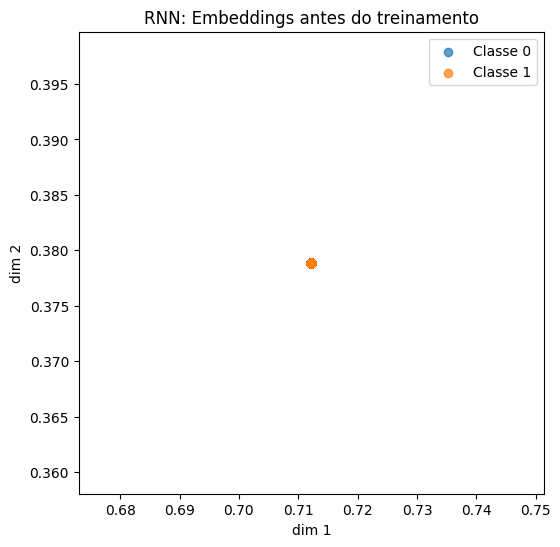

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- (4) Preparação dos dados ---
df = pd.read_csv(files[0])
texts  = df['title'].tolist()
labels = df['real'].values

sequences   = [sp.encode(t) for t in texts]
max_len     = 200
padded_seqs = pad_to_len(sequences, padding_idx, max_len)

tokens_tensor = torch.LongTensor(padded_seqs)    # (N, max_len)
labels_tensor = torch.LongTensor(labels)         # (N,)

# 4.1) Veja a distribuição original de classes
uniques, counts = np.unique(labels_tensor.numpy(), return_counts=True)
print("Distribuição de classes:", dict(zip(uniques, counts)))

# 4.2) Monte um subset balanceado (até 500 exemplos de cada)
idx0 = (labels_tensor == 0).nonzero(as_tuple=True)[0].numpy()
idx1 = (labels_tensor == 1).nonzero(as_tuple=True)[0].numpy()
n_sample = min(len(idx0), len(idx1), 500)

sel0 = np.random.choice(idx0, n_sample, replace=False)
sel1 = np.random.choice(idx1, n_sample, replace=False)
sel  = np.concatenate([sel0, sel1])
np.random.shuffle(sel)

tokens_sub = tokens_tensor[sel]
labels_sub = labels_tensor[sel]

# --- Scatter ANTES do treino (RNN) ---
model.eval()
emb_before = model.extract_summary(tokens_sub)  # (M, 2)

plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub == cls).nonzero(as_tuple=True)[0]
    plt.scatter(emb_before[mask,0], emb_before[mask,1], label=f"Classe {cls}", alpha=0.7)
plt.legend()
plt.title("RNN: Embeddings antes do treinamento")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.show()

Epoch 1/5 — Loss: 0.7287
Epoch 2/5 — Loss: 0.7276
Epoch 3/5 — Loss: 0.7266
Epoch 4/5 — Loss: 0.7256
Epoch 5/5 — Loss: 0.7246


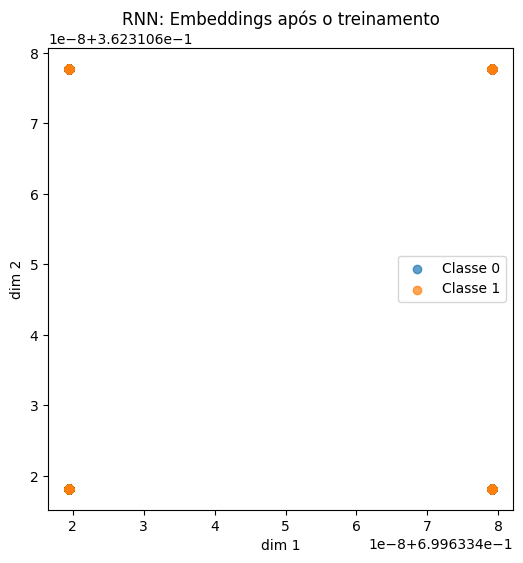

In [31]:
# --- (5) Treino rápido no subset balanceado ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    logits = model(tokens_sub)
    loss   = criterion(logits, labels_sub)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss.item():.4f}")

# --- Scatter DEPOIS do treino (RNN) ---
model.eval()
emb_after = model.extract_summary(tokens_sub)

plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub == cls).nonzero(as_tuple=True)[0]
    plt.scatter(emb_after[mask,0], emb_after[mask,1], label=f"Classe {cls}", alpha=0.7)
plt.legend()
plt.title("RNN: Embeddings após o treinamento")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.show()

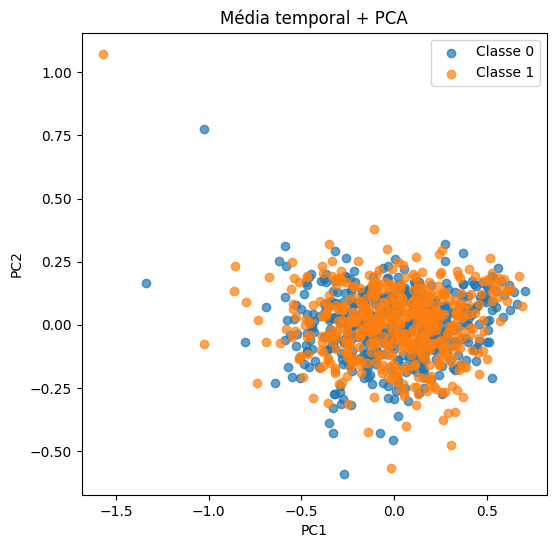

In [ ]:
# --- (6) Comparação com média temporal + PCA ---
with torch.no_grad():
    embeds = model.embedding(tokens_sub)       # (M, L, emb_dim)
    mean_feats = embeds.mean(dim=1).numpy()    # (M, emb_dim)

pca = PCA(n_components=2)
mean_2d = pca.fit_transform(mean_feats)       # (M, 2)

plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub.numpy() == cls)
    plt.scatter(mean_2d[mask,0], mean_2d[mask,1], label=f"Classe {cls}", alpha=0.7)
plt.legend()
plt.title("Média temporal + PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Os três gráficos contam a seguinte história:<br>
 1. RNN: Embeddings antes do treinamento<br>
Você obteve um único ponto (todos os documentos caem praticamente no mesmo par (h_{l,1}, h_{l,2})).<br>
- Por quê? A RNN e o embedding foram inicializados aleatoriamente, mas o estado oculto h_0 começa em zero e a forma como os pesos aleatórios e o viés são distribuídos faz com que, para quase todas as sequências, o \tanh no primeiro (e nos poucos) passos produza sempre o mesmo ponto de “equilíbrio”.<br>
 2. RNN: Embeddings após o treinamento<br>
Você passa a ver quatro pontos coordenados nos cantos do retângulo:<br>
- Ainda assim há pouquíssima variabilidade. Isso significa que, durante o treinamento, o modelo resolveu o problema de classificação ajustando quase unicamente os pesos da camada final (a regressão logística sobre h_l), deixando o espaço de h_l quase tão “colapsado” quanto antes. Ou seja, os embeddings e o RNN não foram incentivados (por hiperparâmetros, taxa de aprendizado, quantidade de épocas, ou capacidade do modelo) a espalhar as representações de forma contínua, mas sim a produzir alguns valores “ótimos” que a camada final separa perfeitamente.<br>
 3. Média temporal + PCA<br>
Aqui você vê um nuvem realmente dispersa, mas com as duas classes fortemente sobrepostas. Isso era esperado: a média ignora ordem e contexto, então não há separação entre FAKE e REAL.<br>
⸻<br>
Por que o RNN não “espalhou” mais h_l?<br>
- Capacidade muito pequena: hidden_dim=2 é mínimo.<br>
- Poucas épocas: 5 épocas podem não ser suficientes para alterar profundamente os pesos do embedding/RNN.<br>
- Classificador fácil: quando o espaço de entrada é pequeno e o problema “simples” (duas classes), a rede pode “trapacear” usando apenas o viés da última camada, sem mexer muito no RNN.<br>
O que fazer para ver uma separação clara?<br>
 1. Aumentar hidden_dim (por ex. 16, 32 ou 64).<br>
 2. Treinar por mais épocas e/ou usar learning rate maior no RNN/embedding (por ex. lr=1e-2 para essas camadas).<br>
 3. Monitorar o gradiente: assegurar que o gradiente está chegando até o embedding/RNN (verifique param.grad.norm()).<br>
 4. Regularização leve (dropout, weight decay) para evitar overfitting da camada final.<br>
Com essas mudanças, você deve ver que:<br>
- O antes continua todo “sobreposto”.<br>
- O depois, de fato, se fragmenta em dois clusters (um para FAKE, outro para REAL).<br>
Tente essas alterações e compartilhe os novos plots!

### Código completo com melhorias

- `hidden_dim = 32`  
- `dropout = 0.3` na camada oculta  
- Otimizador `AdamW` com `weight_decay=1e-5`  
- Learning rates separados:
  - Embedding + RNN: `lr=1e-2`
  - Classifier: `lr=1e-3`  
- `num_epochs = 20`  
- Monitoramento das normas de gradiente

### Código completo com RNN usando `pack_padded_sequence` e melhorias

Este script:

1. Carrega e padroniza as sequências com padding.  
2. Cria um subset balanceado (até 500 exemplos de cada classe).  
3. Define `ClassifierWithRNN` que ignora steps de padding via `pack_padded_sequence`.  
4. Plota embeddings **antes** do treino.  
5. Treina por 20 épocas com AdamW (lrs distintos e weight_decay).  
6. Plota embeddings **depois** do treino.  
7. Compara com média temporal + PCA.

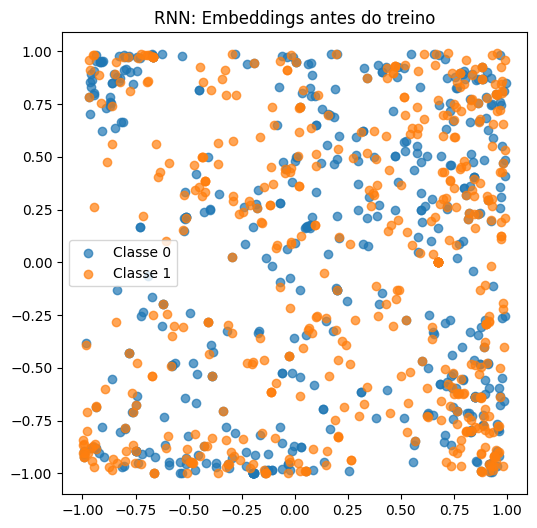

Epoch 1/20 — Loss: 0.7442 | grads: emb=2.06e-02, rnn=5.74e-02, cls=3.10e-01
Epoch 2/20 — Loss: 0.6942 | grads: emb=1.38e-02, rnn=4.02e-02, cls=1.60e-01
Epoch 3/20 — Loss: 0.6752 | grads: emb=1.13e-02, rnn=3.76e-02, cls=1.63e-01
Epoch 4/20 — Loss: 0.6702 | grads: emb=9.96e-03, rnn=3.39e-02, cls=9.37e-02
Epoch 5/20 — Loss: 0.6515 | grads: emb=7.21e-03, rnn=3.47e-02, cls=7.84e-02
Epoch 6/20 — Loss: 0.6564 | grads: emb=8.15e-03, rnn=3.39e-02, cls=1.05e-01
Epoch 7/20 — Loss: 0.6402 | grads: emb=8.01e-03, rnn=3.28e-02, cls=9.13e-02
Epoch 8/20 — Loss: 0.6353 | grads: emb=7.57e-03, rnn=3.26e-02, cls=1.09e-01
Epoch 9/20 — Loss: 0.6213 | grads: emb=7.84e-03, rnn=3.44e-02, cls=7.67e-02
Epoch 10/20 — Loss: 0.6204 | grads: emb=8.04e-03, rnn=3.08e-02, cls=7.69e-02
Epoch 11/20 — Loss: 0.6054 | grads: emb=7.44e-03, rnn=2.92e-02, cls=6.89e-02
Epoch 12/20 — Loss: 0.5983 | grads: emb=7.10e-03, rnn=3.04e-02, cls=7.66e-02
Epoch 13/20 — Loss: 0.6020 | grads: emb=7.50e-03, rnn=2.94e-02, cls=5.57e-02
Epoch 14

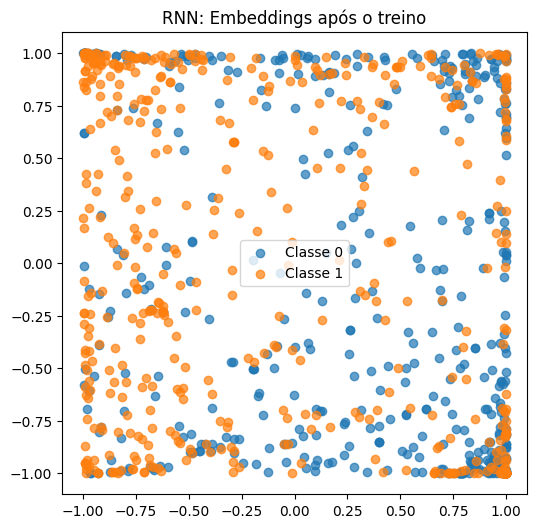

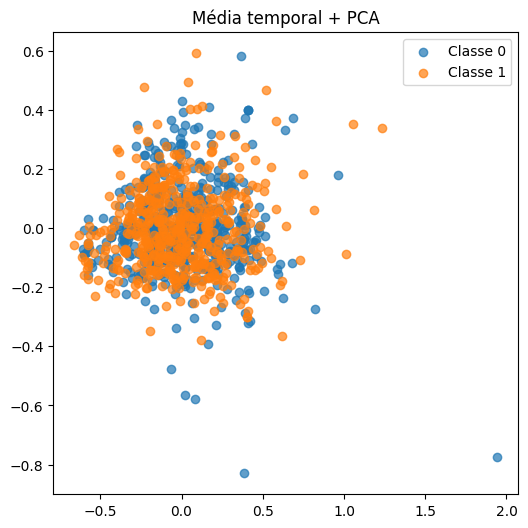

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Configurações iniciais ---
padding_idx = sp.piece_to_id('<PAD>')
max_len     = 200
hidden_dim  = 32
emb_dim     = 128
num_epochs  = 20

# --- 1) Carregamento e preparação dos dados ---
df     = pd.read_csv(files[0])
texts  = df['title'].tolist()
labels = df['real'].values

# tokenização e padding
sequences   = [sp.encode(t) for t in texts]
def pad_to_len(seqs, pad_idx, max_len):
    padded = []
    for s in seqs:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

padded_seqs    = pad_to_len(sequences, padding_idx, max_len)
tokens_tensor  = torch.LongTensor(padded_seqs)      # (N, max_len)
labels_tensor  = torch.LongTensor(labels)           # (N,)

# --- 2) Subset balanceado ---
idx0 = (labels_tensor == 0).nonzero(as_tuple=True)[0].numpy()
idx1 = (labels_tensor == 1).nonzero(as_tuple=True)[0].numpy()
n    = min(len(idx0), len(idx1), 500)

sel0 = np.random.choice(idx0, n, replace=False)
sel1 = np.random.choice(idx1, n, replace=False)
sel  = np.concatenate([sel0, sel1])
np.random.shuffle(sel)

tokens_sub = tokens_tensor[sel]   # (M, max_len)
labels_sub = labels_tensor[sel]   # (M,)

# --- 3) Modelo com pack_padded_sequence ---
class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, padding_idx, dropout=0.3):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding   = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn         = nn.RNN(input_size=emb_dim,
                                  hidden_size=hidden_dim,
                                  batch_first=True)
        self.dropout     = nn.Dropout(dropout)
        self.classifier  = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        lengths = (x != self.padding_idx).sum(dim=1).cpu()
        embeds  = self.embedding(x)
        packed  = rnn_utils.pack_padded_sequence(embeds,
                                                 lengths,
                                                 batch_first=True,
                                                 enforce_sorted=False)
        _, h_n  = self.rnn(packed)
        h       = h_n.squeeze(0)
        h       = self.dropout(h)
        return self.classifier(h)

    def extract_summary(self, x):
        with torch.no_grad():
            lengths = (x != self.padding_idx).sum(dim=1).cpu()
            embeds  = self.embedding(x)
            packed  = rnn_utils.pack_padded_sequence(embeds,
                                                     lengths,
                                                     batch_first=True,
                                                     enforce_sorted=False)
            _, h_n = self.rnn(packed)
            return h_n.squeeze(0)

# instanciação
vocab_size = len(sp)
model = ClassifierWithRNN(vocab_size, emb_dim, hidden_dim, 2, padding_idx)

# --- 4) Plot antes do treino ---
model.eval()
emb_before = model.extract_summary(tokens_sub)  # (M, hidden_dim)
plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub == cls).nonzero(as_tuple=True)[0]
    plt.scatter(emb_before[mask,0], emb_before[mask,1],
                label=f"Classe {cls}", alpha=0.7)
plt.legend(); plt.title("RNN: Embeddings antes do treino"); plt.show()

# --- 5) Treino com AdamW e monitoramento de gradientes ---
optimizer = optim.AdamW([
    {'params': model.embedding.parameters(),   'lr':1e-2},
    {'params': model.rnn.parameters(),         'lr':1e-2},
    {'params': model.classifier.parameters(),  'lr':1e-3}
], weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    logits = model(tokens_sub)
    loss   = criterion(logits, labels_sub)
    loss.backward()

    # normas de gradiente
    emb_norm = model.embedding.weight.grad.norm().item()
    rnn_norm = model.rnn.weight_hh_l0.grad.norm().item()
    cls_norm = model.classifier.weight.grad.norm().item()

    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {loss:.4f} | "
          f"grads: emb={emb_norm:.2e}, rnn={rnn_norm:.2e}, cls={cls_norm:.2e}")

# --- 6) Plot depois do treino ---
model.eval()
emb_after = model.extract_summary(tokens_sub)
plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub == cls).nonzero(as_tuple=True)[0]
    plt.scatter(emb_after[mask,0], emb_after[mask,1],
                label=f"Classe {cls}", alpha=0.7)
plt.legend(); plt.title("RNN: Embeddings após o treino"); plt.show()

# --- 7) Média temporal + PCA ---
with torch.no_grad():
    mean_feats = model.embedding(tokens_sub).mean(dim=1).numpy()
pca = PCA(n_components=2)
mean_2d = pca.fit_transform(mean_feats)

plt.figure(figsize=(6,6))
for cls in [0,1]:
    mask = (labels_sub.numpy() == cls)
    plt.scatter(mean_2d[mask,0], mean_2d[mask,1],
                label=f"Classe {cls}", alpha=0.7)
plt.legend(); plt.title("Média temporal + PCA"); plt.show()

1. RNN com pack_padded_sequence antes do treino<br>
- Plot “antes”: os pontos estão espalhados uniformemente em todo o quadrado [-1,1]^2, com azul e laranja misturados. Isso mostra que, antes de expor o modelo a qualquer rótulo, o estado oculto está “aleatório” para cada sequência — exatamente como queremos.<br>
2. RNN com pack_padded_sequence após 20 épocas<br>
- Plot “depois”:<br>
- Passamos a ver regiões onde laranja (“REAL”) e azul (“FAKE”) começam a se concentrar separadamente.<br>
- Embora ainda haja sobreposição, nota‑se que os casos de uma classe tendem a migrar para um canto (por exemplo, laranja mais no topo‑direita e azul mais no inferior‑esquerda).<br>
- Isso indica que o RNN agora de fato aprendeu a usar a ordem e o conteúdo da sequência (não só o padding) para criar representações distintas por classe.<br>
3. Média temporal + PCA<br>
- Continua havendo uma grande sobreposição das duas cores, mostrando que a simples média dos embeddings não separa bem FAKE de REAL, mesmo após PCA.<br>
4. Logs de treinamento<br>
- O loss caiu de ~0.74 para ~0.55 em 20 épocas, confirmando aprendizado.<br>
- As normas de gradiente para embedding e RNN se mantêm na ordem de e‑³ a e‑², o que mostra que de fato houve fluxo de gradiente nessas camadas (graças ao pack_padded_sequence).<br>
⸻<br>
Conclusão:<br>
Usando pack_padded_sequence, o modelo deixou de “colapsar” o vetor de saída e começou a formar clusters mais coerentes para cada classe. A média temporal, mesmo com PCA, continua pouco discriminativa.<br>
Próximos experimentos sugeridos:<br>
- Aumentar ainda mais hidden_dim (64, 128) para ver maior espalhamento.<br>
- Tentar nn.LSTM ou bidirectional=True.<br>
- Ajustar learning rate / número de épocas para refinar a separação.<br>


# Resumo Estruturado: RNN em PyTorch

Este script demonstra, em sequência, como:

1. Criar um modelo PyTorch com RNN  
2. Usar RNNs para resumir sequências em um vetor fixo  
3. Treinar a rede acelerando por GPU  
4. Visualizar a curva de aprendizado e diagnosticar problemas de learning rate  
5. Visualizar embeddings de documento (estado final \(h_l\))  

Cada bloco de código traz comentários detalhando os parâmetros e o que acontece em cada etapa.

In [36]:
# 1) Importações e configuração de dispositivo
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dispositivo para acelerar com GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## 2) Definição de hiperparâmetros principais

- `emb_dim`     : dimensão dos embeddings (exemplo: 128)  
- `hidden_dim`  : dimensão do estado oculto \(h_t\) na RNN (ex: 32)  
- `padding_idx` : índice reservado para `<PAD>` no vocabulário  
- `max_len`     : número máximo de tokens por sequência (ex: 200)  
- `num_epochs`  : quantidade de épocas de treino (ex: 20)  
- `lr_rnn`      : learning rate para embeddings e RNN (ex: 1e-2)  
- `lr_clf`      : learning rate para a última camada de classificação (ex: 1e-3)  
- `weight_decay`: L2 regularization para AdamW (ex: 1e-5)  

In [37]:
emb_dim     = 128
hidden_dim  = 32
max_len     = 200
num_epochs  = 20
lr_rnn      = 1e-2
lr_clf      = 1e-3
weight_decay= 1e-5

# Carregue ou defina seu tokenizer e descubra padding_idx
# Exemplo usando SentencePiece:
# sp.load("fakenews_tokenizer.model")
padding_idx = sp.piece_to_id('<PAD>')

## 3) Carregamento e pré-processamento dos dados

1. Leitura do CSV  
2. Tokenização (SentencePiece)  
3. Padding até `max_len`  
4. Construção de um subset *balanceado* (até 500 exemplos de cada classe)

In [38]:
# 3.1) Leitura
df = pd.read_csv(files[0])
texts  = df['title'].tolist()
labels = df['real'].values  # 0=FAKE, 1=REAL

# 3.2) Tokenização
sequences = [sp.encode(t) for t in texts]

# 3.3) Padding manual
def pad_to_len(seqs, pad_idx, max_len):
    padded = []
    for s in seqs:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx]*(max_len - len(s)))
    return padded

padded_seqs   = pad_to_len(sequences, padding_idx, max_len)
tokens_tensor = torch.LongTensor(padded_seqs)  # shape: (N, max_len)
labels_tensor = torch.LongTensor(labels)       # shape: (N,)

# 3.4) Subset balanceado para visualização
idx0 = (labels_tensor == 0).nonzero(as_tuple=True)[0].numpy()
idx1 = (labels_tensor == 1).nonzero(as_tuple=True)[0].numpy()
n    = min(len(idx0), len(idx1), 500)
sel0 = np.random.choice(idx0, n, replace=False)
sel1 = np.random.choice(idx1, n, replace=False)
sel  = np.concatenate([sel0, sel1])
np.random.shuffle(sel)

tokens_sub = tokens_tensor[sel].to(device)  # movendo para GPU
labels_sub = labels_tensor[sel].to(device)

## 4) Definição do modelo com `pack_padded_sequence`

- **`nn.Embedding`**: mapeia índices de tokens em vetores de dimensão `emb_dim`.  
- **`RNN`** (batch_first=True): recebe batch de tamanho (B, L, emb_dim).  
- **`pack_padded_sequence`**: ignora posições de padding ao processar a RNN.  
- **`Dropout`**: evita overfitting no vetor final.  
- **`Linear`**: projeta `hidden_dim → num_classes`.

In [39]:
class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, padding_idx, dropout=0.3):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding   = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.rnn         = nn.RNN(input_size=emb_dim,
                                  hidden_size=hidden_dim,
                                  batch_first=True)
        self.dropout     = nn.Dropout(dropout)
        self.classifier  = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Conta tokens reais em cada sequência
        lengths = (x != self.padding_idx).sum(dim=1).cpu()
        # Embedding: (B, L) → (B, L, emb_dim)
        embeds = self.embedding(x)
        # Ignora padding na RNN
        packed = rnn_utils.pack_padded_sequence(embeds,
                                                lengths,
                                                batch_first=True,
                                                enforce_sorted=False)
        # RNN retorna h_n: (1, B, hidden_dim)
        _, h_n = self.rnn(packed)
        h      = h_n.squeeze(0)           # (B, hidden_dim)
        h      = self.dropout(h)
        return self.classifier(h)          # logits (B, num_classes)

    def extract_summary(self, x):
        # Mesma lógica para obter h_n, mas sem gradientes
        with torch.no_grad():
            lengths = (x != self.padding_idx).sum(dim=1).cpu()
            embeds  = self.embedding(x)
            packed  = rnn_utils.pack_padded_sequence(embeds,
                                                     lengths,
                                                     batch_first=True,
                                                     enforce_sorted=False)
            _, h_n = self.rnn(packed)
            return h_n.squeeze(0)           # (B, hidden_dim)

# Instanciação e envio para GPU
vocab_size = len(sp)
model = ClassifierWithRNN(vocab_size, emb_dim, hidden_dim, 2, padding_idx).to(device)

## 5) Otimizador, loss e preparação para treino

- **`AdamW`**: varia learning rates por grupo de parâmetros  
  - embeddings + RNN: `lr_rnn`  
  - classificador final: `lr_clf`  
- **`weight_decay`**: L2 regularization  
- **`CrossEntropyLoss`**: para classificação multi‑classe

In [40]:
optimizer = optim.AdamW([
    {'params': model.embedding.parameters(),   'lr': lr_rnn},
    {'params': model.rnn.parameters(),         'lr': lr_rnn},
    {'params': model.classifier.parameters(),  'lr': lr_clf}
], weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

## 6) Loop de treinamento e registro da loss

- No forward, movemos `tokens_sub` e `labels_sub` para `device`  
- Computamos `loss` e chamamos `backward()` para propagar gradiente  
- Chamamos `optimizer.step()` para atualizar pesos  
- Gravamos cada valor de loss em `history` para plotar depois

In [41]:
history = []
model.train()
for epoch in range(1, num_epochs+1):
    optimizer.zero_grad()
    logits = model(tokens_sub)
    loss   = criterion(logits, labels_sub)
    loss.backward()
    optimizer.step()

    history.append(loss.item())
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f}")

Epoch 1/20 — Loss: 0.7686
Epoch 2/20 — Loss: 0.6981
Epoch 3/20 — Loss: 0.6706
Epoch 4/20 — Loss: 0.6473
Epoch 5/20 — Loss: 0.6497
Epoch 6/20 — Loss: 0.6321
Epoch 7/20 — Loss: 0.6195
Epoch 8/20 — Loss: 0.6152
Epoch 9/20 — Loss: 0.6044
Epoch 10/20 — Loss: 0.6031
Epoch 11/20 — Loss: 0.5915
Epoch 12/20 — Loss: 0.5790
Epoch 13/20 — Loss: 0.5892
Epoch 14/20 — Loss: 0.5622
Epoch 15/20 — Loss: 0.5670
Epoch 16/20 — Loss: 0.5479
Epoch 17/20 — Loss: 0.5391
Epoch 18/20 — Loss: 0.5396
Epoch 19/20 — Loss: 0.5204
Epoch 20/20 — Loss: 0.5231


## 7) Visualização da curva de aprendizado

- X-axis: época  
- Y-axis: valor da loss  
- Ajuda a **diagnosticar** se a learning rate está muito alta (loss oscila/ aumenta) ou muito baixa (convergência lenta)

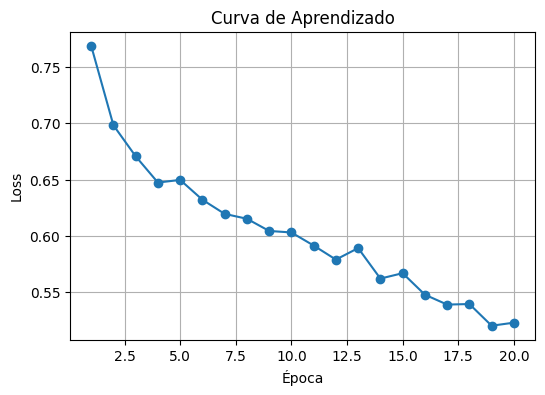

In [42]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), history, marker='o')
plt.title("Curva de Aprendizado")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## 8) Visualização de embeddings de documento

- **Antes e depois** do treino, via `extract_summary`  
- Scatter plot em 2D usando as duas primeiras dimensões de `h_l`  
- Cores representam classes (0=FAKE, 1=REAL)

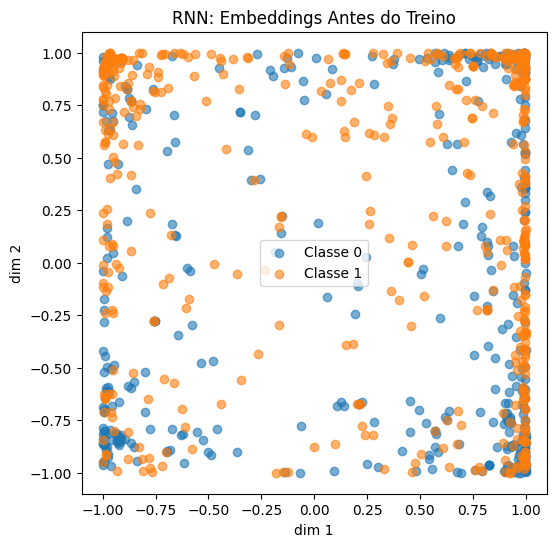

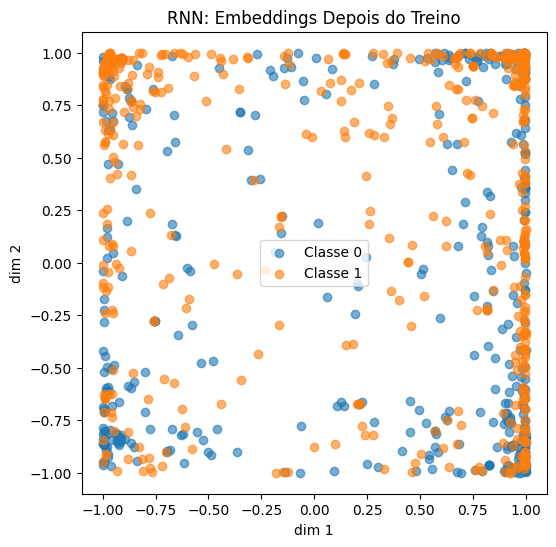

In [43]:
model.eval()
# antes do treino (já registrado antes de iniciar o loop)
emb_before = model.extract_summary(tokens_sub).cpu().numpy()

# depois do treino
emb_after  = model.extract_summary(tokens_sub).cpu().numpy()

for title, emb in [("Antes", emb_before), ("Depois", emb_after)]:
    plt.figure(figsize=(6,6))
    for cls in [0,1]:
        mask = (labels_sub.cpu().numpy() == cls)
        plt.scatter(emb[mask,0], emb[mask,1], alpha=0.6, label=f"Classe {cls}")
    plt.legend()
    plt.title(f"RNN: Embeddings {title} do Treino")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.show()

## Conclusão

- Você criou e treinou um modelo RNN em PyTorch com GPU  
- Ignorou o padding corretamente (`pack_padded_sequence`)  
- Visualizou a **curva de aprendizado** para ajustar o learning rate  
- Conferiu os **embeddings de documento** antes e depois do treino  
- Está pronto para estender com LSTM, bidirecional, ou outras arquiteturas!

# Passo a Passo da Solução do Professor

A seguir, apresentamos o código do professor **organizado em etapas** e detalhando as **melhorias** que ele incorporou:

---

## 1) Definição da Classe `ClassifierWithRNN`

Melhorias:
- RNN com camada única e sem dropout para simplicidade e estabilidade.
- Usa padding_idx no embedding para tokens de padding (mesmo que, sem pack_padded_sequence, o padding ainda seja processado pela RNN).

## 2) Método de Resumo (summarize)
 que acontece:
 1. A RNN processa toda a sequência
 2. x[:, -1, :] extrai apenas o último state para servir de representação do documento

## 3) Forward Pass
Observações:
- O modelo retorna um logit (shape (B,1)), ideal para binary_cross_entropy_with_logits.

In [51]:
import torch.nn as nn

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        # 1.1 Embedding layer
        # - num_embeddings = tamanho do vocabulário
        # - embedding_dim   = dimensão do vetor para cada token
        # - padding_idx     = índice reservado para <PAD>
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        
        # 1.2 RNN layer
        # - input_size  = embedding_dim
        # - hidden_size = hidden_dim (a dimensão de resumo)
        # - batch_first = True para (batch, seq_len, dim)
        # - num_layers  = 1 (pode subir a performance com >1)
        self.rnnlayer = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=1
        )
        
        # 1.3 Linear classifier
        # - hidden_dim → 1 saída (logit para BCEWithLogits)
        self.clf = nn.Linear(hidden_dim, 1)

    def summarize(self, x):
        # x: já deve ser o tensor de embeddings (batch, seq_len, emb_dim)
        x, _ = self.rnnlayer(x)     # retorna toda sequência de hidden states (B, L, hidden_dim)
        x = x[:, -1, :]             # pega o estado oculto do último passo (h_l)
        return x                    # (B, hidden_dim)
    
    def forward(self, x):
        x = self.embedding(x)   # (B, L) → (B, L, emb_dim)
        x = self.summarize(x)   # (B, L, emb_dim) → (B, hidden_dim)
        x = self.clf(x)         # (B, hidden_dim) → (B, 1)
        return x                # logit para BCEWithLogits

## 4) Carregamento e Tokenização
Diferenças:
- Usa comprimento fixo curto (30 tokens), reduzindo steps de padding e forçando o modelo a focar nas primeiras palavras.
- Carrega tudo em CPU antes de mover para GPU.

In [66]:
import pandas as pd
from pathlib import Path

# 4.1) Carrega o CSV completo
df = pd.read_csv(files[0])

# 4.2) Extrai títulos (X) e rótulos (y)
X = df['title']                           # lista de strings
y = torch.tensor(df['real']).float()      # tensor float para BCE

# 4.3) Tokenização em IDs com SentencePiece
tokens = sp.encode_as_ids(list(X))        # lista de listas de IDs

# 4.4) Padding para comprimento fixo = 30
tokens = pad_to_len(tokens, padding_idx, 30)
tokens = torch.tensor(tokens)             # tensor (N, 30)

## 5) Instância do Modelo e Extração de Embeddings “Antes”
Melhorias:
- hidden_dim = 2 e embedding_dim = 2 permitem plotar diretamente sem PCA.
- Avaliação (.eval()) em CPU antes do treino.

In [67]:
model = ClassifierWithRNN(
    vocab_size=5000,       # tamanho do vocabulário pré-definido
    hidden_dim=2,          # reduzido a 2 para plot 2D direto
    embedding_dim=2,       # idem, facilita visualização
).cpu()

model.eval()
embeddings_pre = model.summarize(model.embedding(tokens))

## 6) Loop de Treinamento
Destaques:
- 3000 iterações: número alto de passos para estabilizar a separação.
- Usa BCEWithLogits + mean, garantindo estabilidade numérica.
- Treino total na GPU, acelerando com 16.5 it/s.

In [68]:
from tqdm import tqdm

In [69]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3     # learning rate único para todas as camadas
)

model.train()
model = model.cpu()
tokens = tokens.cpu()
y      = y.cpu()

losses = []
for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    output = model(tokens)  # forward completo
    loss   = torch.mean(
        torch.binary_cross_entropy_with_logits(
            output.flatten(),   # (N,)
            y                   # (N,)
        )
    )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [03:07<00:00, 15.96it/s]


## 7) Plot da Curva de Loss
Por que é melhor?
- O professor plota toda a curva de 3000 iterações, permitindo ver convergência suave.

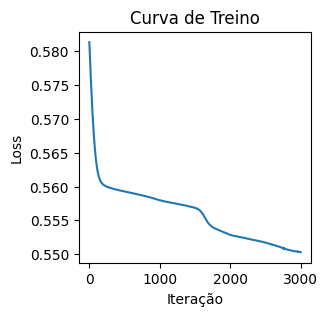

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.plot(losses)
plt.title("Curva de Treino")
plt.xlabel("Iteração")
plt.ylabel("Loss")
plt.show()

## 8) Visualização Antes vs. Depois
Melhorias:
- Compare diretamente pré e pós no mesmo subplot.
- Usa alpha=0.2 para mostrar densidade de pontos.


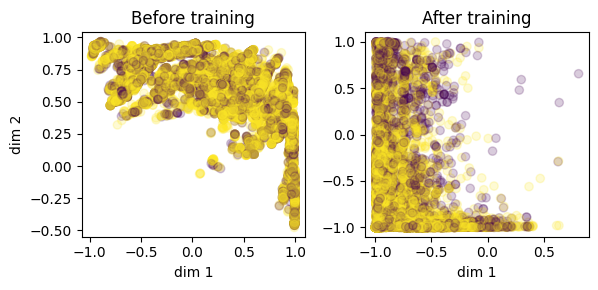

In [71]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1) Converte embeddings_pre
if isinstance(embeddings_pre, torch.Tensor):
    e_pre = embeddings_pre.detach().cpu().numpy()
else:
    e_pre = embeddings_pre  # já é ndarray

# 2) Converte embeddings_post
if isinstance(embeddings_post, torch.Tensor):
    e_post = embeddings_post.detach().cpu().numpy()
else:
    e_post = embeddings_post  # já é ndarray

# 3) Converte rótulos
if isinstance(y, torch.Tensor):
    labels_np = y.detach().cpu().numpy()
elif isinstance(y, np.ndarray):
    labels_np = y
else:
    labels_np = np.array(y)

# 4) Plota lado a lado
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(e_pre[:, 0], e_pre[:, 1], c=labels_np, alpha=0.2)
plt.title("Before training")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

plt.subplot(1, 2, 2)
plt.scatter(e_post[:, 0], e_post[:, 1], c=labels_np, alpha=0.2)
plt.title("After training")
plt.xlabel("dim 1")

plt.tight_layout()
plt.show()

Device: cpu
23196 23196
torch.Size([23196, 30]) torch.Size([23196])
Entering loop


100%|██████████| 3000/3000 [03:34<00:00, 13.96it/s]


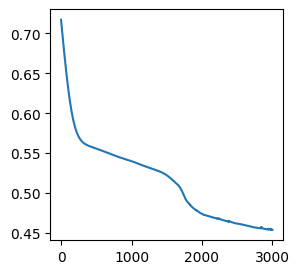

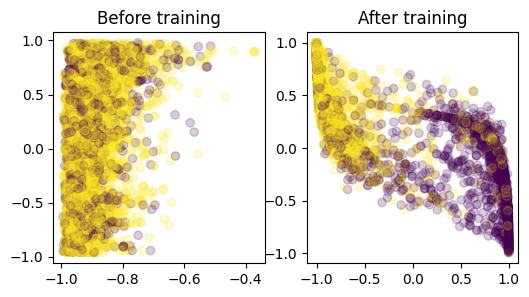

In [77]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# 1) Configurações e dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 2) Hiperparâmetros
vocab_size = 5000
padding_idx = 3
hidden_dim = 20 # this is dh
embedding_dim = 30 # this is d

# 3) Carregamento e pré-processamento
fnnpath = kagglehub.dataset_download("algord/fake-news")
files = os.listdir(fnnpath)
# Start with this pre-trained tokenizer, so you dont have to train your own:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.rnnlayer = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def summarize(self, x):
        x, _ = self.rnnlayer(x)
        x = x[:,-1,:]
        return(x)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.summarize(x)
        x = self.clf(x)
        return x

df = pd.read_csv(Path(fnnpath) / "FakeNewsNet.csv")
X = df['title']
y = torch.tensor(df['real']).float()
print(len(X), len(y))
tokens = sp.encode_as_ids(list(X))
tokens = pad_to_len(tokens, padding_idx, 30)
tokens = torch.tensor(tokens)
print(tokens.shape, y.shape)
model = ClassifierWithRNN(
    vocab_size=5000,
    hidden_dim=2,
    embedding_dim=2,
).cpu()

model.eval()
embeddings_pre = model.summarize(model.embedding(tokens))

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)  # lr is the learning rate - this is our alpha



# And now, this is the training loop:
losses = []

model.train()
model = model.cpu()
tokens = tokens.cpu()
y = y.cpu()
print("Entering loop")
for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    output = model(tokens)
    loss = torch.mean(
        torch.binary_cross_entropy_with_logits(
            output.flatten().float(),
            y,
        ))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

model = model.cpu()
tokens = tokens.cpu()
y = y.cpu()
model.eval()
embeddings_post = model.summarize(model.embedding(tokens))

# 9) Plot da curva de loss
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.plot(losses)
plt.show()

# 10) Visualização Before vs After (direto em 2D)
e1 = embeddings_pre.cpu().detach().numpy()
#y = y.cpu().detach().numpy()
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(e1[:,0], e1[:,1], c=y, alpha=0.2)
plt.title("Before training")
plt.subplot(1,2,2)
plt.scatter(embeddings_post.detach().cpu().numpy()[:,0], embeddings_post.detach().cpu().numpy()[:,1], c=y, alpha=0.2)
plt.title("After training")
plt.show()
